In [235]:
# TODO - add tau minimization as in the paper

def get_N_axes(jet, N, R=1.0):
    """
    Calculate the N exclusive axes for a given jet using the kT algorithm.

    Parameters:
    - jet: the jet for which to calculate axes.
    - N: the number of axes to calculate.
    - R: the jet radius parameter for the clustering algorithm.
    
    Returns:
    - A list of axes (pseudojets).
    """
    constituents = [fj.PseudoJet(c.px(), c.py(), c.pz(), c.e()) for c in jet.constituents()]
    axesdef = fj.JetDefinition(fj.kt_algorithm, 1000)
    cluster = fj.ClusterSequence(constituents, axesdef)
    return cluster.exclusive_jets(N)

def N_subjettiness(jet, N, R=1.0, beta=1.0):
    """
    Calculate the N-subjettiness value for a given jet and set of axes.

    Parameters:
    - axes: the axes around which to calculate tau_N.
    - jet: the jet for which to calculate tau_N.
    - R: the jet radius parameter for the clustering algorithm.
    - beta: the angular exponent in the N-subjettiness calculation.
    
    Returns:
    - The tau_N 
    """

    axes = get_N_axes(jet, N, R) 
    tau_N = 0.0
    d0 = 0.0
    for c in jet.constituents():
        tau_N += c.pt() * min([c.delta_R(ax)**beta for ax in axes])
        d0 += c.pt() * (R**beta)
    return tau_N / d0 

# LHC Olympics: cluster jets

Cluster jets and compute high-level features

In [236]:
def get_constituents(jet, relative_coords=True, max_particles=100):
    pt = jet.pt()
    eta = jet.eta()
    phi = jet.phi()
    constituents = []
    N = len(jet.constituents())
        
    for c in jet.constituents():
        feats = [c.pt() / pt, eta - c.eta(), phi - c.phi(), 1] if relative_coords else [c.pt(), c.eta(), c.phi(), 1]  # masked
        constituents += [feats]

    constituents = np.array(constituents)
    constituents = constituents[constituents[:,0].argsort()[::-1]]
    assert N <= max_particles, "Number of particles in jet is greater than max_particles"
    constituents = np.pad(constituents, ((0, max_particles - N), (0,0)), 'constant')

    return constituents

def get_dijet_dataset_low_level(file, particle_level=False, stop=None, jet_algorithm='antikt', R=1.0, pt_jet_min=20.0, max_particles=280):

    data = pd.read_hdf(file,  stop=stop).to_numpy()
    events = data[..., :-1].reshape(data.shape[0], 700, -1)
    labels = data[..., -1]
    jet_features = []
    particle_features = []

    for event in events:
        event = event[event[:,0] != 0]

        pseudojets = []
        for particle in event:
            pj = fj.PseudoJet()
            pj.reset_PtYPhiM(particle[0], particle[1], particle[2], 0.0)
            pseudojets.append(pj)

        if jet_algorithm=='antikt': algorithm = fj.antikt_algorithm
        elif jet_algorithm=='cambridge': algorithm = fj.cambridge_algorithm
        elif jet_algorithm=='kt': algorithm = fj.kt_algorithm

        jetdef = fj.JetDefinition(algorithm, R)
        cluster = fj.ClusterSequence(pseudojets, jetdef)
        jets = fj.sorted_by_pt(cluster.inclusive_jets(pt_jet_min))
 
        if len(jets)>=2:
            j0, j1 = jets[0], jets[1]
            N0 = len(j0.constituents())
            N1 = len(j1.constituents())

            jet_features.append([(j0 + j1).m(), j0.delta_R(j1), 
                                j0.pt(), j0.eta(), j0.phi(), j0.m(), N0,
                                j1.pt(), j1.eta(), j1.phi(), j1.m(), N1])

            if particle_level:
                consitutents_1 = get_constituents(j0, max_particles=max_particles)
                consitutents_2 = get_constituents(j1, max_particles=max_particles)
                particle_features.append(np.concatenate([consitutents_1, consitutents_2], axis=-1))
        
    # save jets:
    with h5py.File('../data/LHCOlympics2020/events_anomalydetection_low_level.h5', 'w') as f:
        jet_features = np.array(jet_features)
        jet_features = np.concatenate([labels[:, None], jet_features], axis=-1)
        f.create_dataset('jet features', data=jet_features)
        
        if particle_level: 
            particle_features = np.array(particle_features)
            f.create_dataset('particle features', data=particle_features)

def get_dijet_dataset_high_level(file, 
                                stop=None, 
                                jet_level=None, 
                                particle_level=False, 
                                jet_algorithm='antikt', 
                                R=1.0, 
                                pt_jet_min=20.0, 
                                max_particles=280):

    data = pd.read_hdf(file,  stop=stop).to_numpy()
    events = data[..., :-1].reshape(data.shape[0], 700, -1)
    labels = data[..., -1]
    jet_features = []
    jet_features_cathode = []
    particle_features = []

    for event in events:
        event = event[event[:,0] != 0]

        pseudojets = []
        for particle in event:
            pj = fj.PseudoJet()
            pj.reset_PtYPhiM(particle[0], particle[1], particle[2], 0.0)
            pseudojets.append(pj)

        if jet_algorithm=='antikt': algorithm = fj.antikt_algorithm
        elif jet_algorithm=='cambridge': algorithm = fj.cambridge_algorithm
        elif jet_algorithm=='kt': algorithm = fj.kt_algorithm

        jetdef = fj.JetDefinition(algorithm, R)
        cluster = fj.ClusterSequence(pseudojets, jetdef)
        jets = fj.sorted_by_pt(cluster.inclusive_jets(pt_jet_min))
 
        if len(jets)>=2:

            j0, j1 = jets[0], jets[1]
            N0 = len(j0.constituents())
            N1 = len(j1.constituents())
            tau1_0, tau1_1 = N_subjettiness(j0, 1, R) if N0 > 0 else 0, N_subjettiness(j1, 1, R) if N1 > 0 else 0
            tau2_0, tau2_1 = N_subjettiness(j0, 2, R) if N0 > 1 else 0, N_subjettiness(j1, 2, R) if N1 > 1 else 0
            tau3_0, tau3_1 = N_subjettiness(j0, 3, R) if N0 > 2 else 0, N_subjettiness(j1, 3, R) if N1 > 2 else 0

            jet_features.append([j0.px(), j0.py(), j0.pz(), j0.m(), tau1_0, tau2_0, tau3_0, N0,
                                 j1.px(), j1.py(), j1.pz(), j1.m(), tau1_1, tau2_1, tau3_1, N1])
            
            jet_features_cathode.append([(j0 + j1).m(), j0.delta_R(j1), j0.m(), j0.m() - j1.m(), tau2_0 / tau1_0,  tau2_1 / tau1_1])
            consitutents_1 = get_constituents(j0, max_particles=max_particles)
            consitutents_2 = get_constituents(j1, max_particles=max_particles)
            particle_features.append(np.concatenate([consitutents_1, consitutents_2], axis=-1))

    jet_features = np.array(jet_features_cathode) if jet_level == 'cathode' else np.array(jet_features) 
    jet_features = np.concatenate([labels[:, None], jet_features], axis=-1)
    particle_features = np.array(particle_features)

    # save jets:
    with h5py.File('../data/LHCOlympics2020/events_anomalydetection_high_level.h5', 'w') as f:
        f.create_dataset('jet features', data=jet_features)
        if particle_level: f.create_dataset('particle features', data=particle_features)


In [ ]:
get_dijet_dataset_low_level(file='../data/LHCOlympics2020/events_anomalydetection.h5', 
                            stop=500000, 
                            jet_algorithm='antikt', 
                            R=1.0, 
                            pt_jet_min=20.0, 
                            max_particles=275)

### get jets from h5 file

In [6]:
file = '../data/LHCOlympics2020/events_anomalydetection_dijets_high_level.h5'
f = h5py.File(file, 'r') 
dijets = f['dijet features']
jets = f['jet features']
# particles = f['particle features']

In [183]:
import pandas as pd
file = '../data/LHCOlympics2020/events_anomalydetection_v2.features.h5'
df = pd.read_hdf(file,  stop=1000000)
print(df)

               pxj1         pyj1         pzj1         mj1      tau1j1  \
0      -1467.239990   611.502014   511.101990   38.896000    8.290660   
1      -1211.239990   347.315002   547.963013  389.532013  191.804001   
2      -1229.619995   649.857971     8.089170   72.155502   47.168098   
3       -693.304016 -1046.729980  1716.910034   55.797798   24.788601   
4      -1488.199951   -25.370100   -30.989700   84.891502   26.878799   
...             ...          ...          ...         ...         ...   
999995  -286.550995 -1310.829956 -1510.910034  147.516998   60.997799   
999996   918.562988   951.195984 -1622.569946   32.242199    5.894100   
999997  1447.219971  -547.710999   827.945007  396.112000  181.406998   
999998   200.035995 -1252.869995    27.924900  363.790985  139.281998   
999999  -811.379028  1050.810059     5.019200  150.214996   92.509003   

            tau2j1     tau3j1         pxj2         pyj2         pzj2  \
0         4.836080   4.260190  1403.579956  -674.55

/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_2308/3860242599.py:34: RuntimeWarning: invalid value encountered in divide
  axs[1, 0].hist(jets[...,6][mask]/jets[...,5][mask], bins=40, histtype='step', color='darkred', label='leading', density=True)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_2308/3860242599.py:35: RuntimeWarning: invalid value encountered in divide
  axs[1, 0].hist(jets[...,14][mask]/jets[...,13][mask], bins=40, histtype='step', color='darkblue', label='subleading', density=True)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_2308/3860242599.py:41: RuntimeWarning: invalid value encountered in divide
  axs[1, 1].hist(jets[...,7][mask]/jets[...,6][mask], bins=40, histtype='step', color='darkred', label='leading', density=True)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_2308/3860242599.py:42: RuntimeWarning: invalid value encountered in divide
  axs[1, 1].hist(jets[...,15][mask]/jets[...,14][mask], bins=40, histtype=

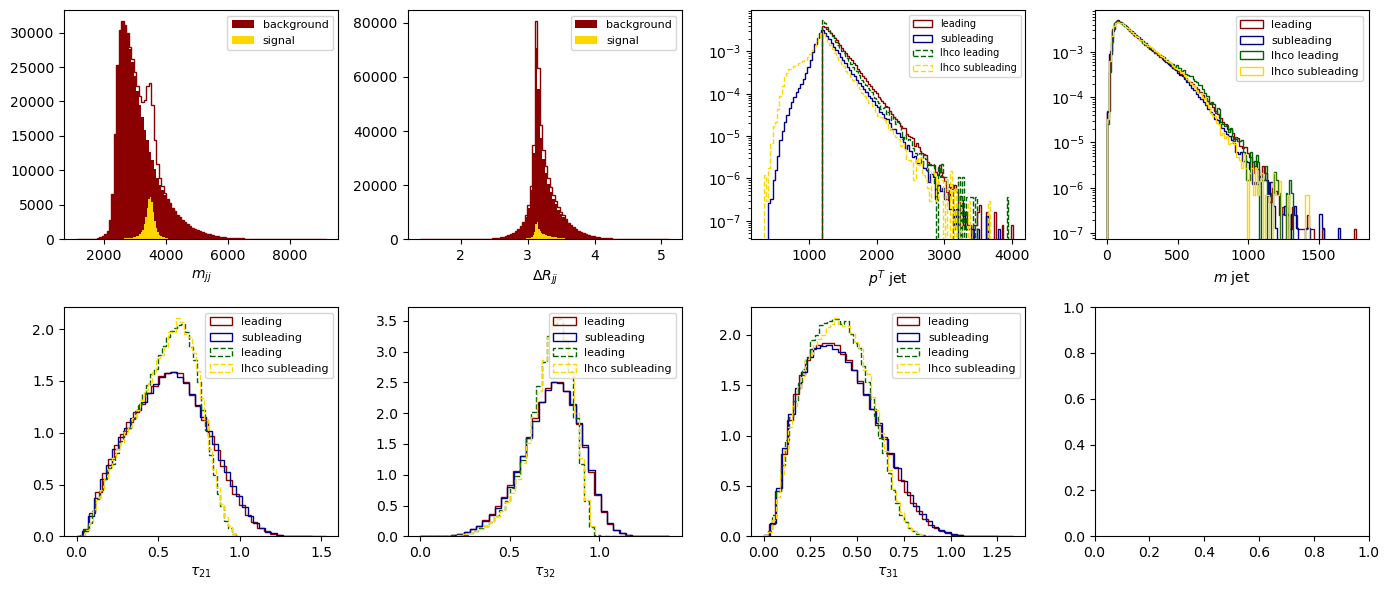

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(14, 6))

b = dijets[...,0]==0
s = dijets[...,0]==1

axs[0, 0].hist(dijets[...,1], bins=100, histtype='step', color='darkred')
axs[0, 0].hist(dijets[...,1][b], bins=100, histtype='stepfilled', color='darkred', label='background')
axs[0, 0].hist(dijets[...,1][s], bins=100, histtype='stepfilled', color='gold', label='signal')
axs[0, 0].set_xlabel(r'$m_{jj}$')
axs[0, 0].legend(fontsize=8, loc='upper right')

axs[0, 1].hist(dijets[...,2], bins=100, histtype='step', color='darkred')
axs[0, 1].hist(dijets[...,2][b], bins=100, histtype='stepfilled', color='darkred', label='background')
axs[0, 1].hist(dijets[...,2][s], bins=100, histtype='stepfilled', color='gold', label='signal')
axs[0, 1].set_xlabel(r'$\Delta R_{jj}$')
axs[0, 1].legend(fontsize=8, loc='upper right')

mask = jets[...,0]==0

axs[0, 2].hist(np.sqrt(jets[...,1][mask]**2 + jets[...,2][mask]**2) , bins=100, histtype='step', color='darkred', label='leading', log=True, density=True)
axs[0, 2].hist(np.sqrt(jets[...,9][mask]**2 + jets[...,10][mask]**2), bins=100, histtype='step', color='darkblue', label='subleading', log=True, density=True)
axs[0, 2].hist(np.sqrt(df['pxj1']**2 + df['pyj1']**2), bins=100, histtype='step', color='darkgreen', ls='--', label='lhco leading', log=True, density=True)
axs[0, 2].hist(np.sqrt(df['pxj2']**2 + df['pyj2']**2), bins=100, histtype='step', color='gold',ls='--',label='lhco subleading', log=True, density=True)
axs[0, 2].set_xlabel(r'$p^T$ jet')
axs[0, 2].legend(fontsize=7, loc='upper right')

axs[0, 3].hist(jets[...,4][mask], bins=100, histtype='step', color='darkred', label='leading', log=True, density=True)
axs[0, 3].hist(jets[...,12][mask], bins=100, histtype='step', color='darkblue', label='subleading', log=True, density=True)
axs[0, 3].hist(df['mj1'], bins=100, histtype='step', color='darkgreen', label='lhco leading', log=True, density=True)
axs[0, 3].hist(df['mj2'], bins=100, histtype='step', color='gold', label='lhco subleading', log=True, density=True)
axs[0, 3].set_xlabel(r'$m$ jet')
axs[0, 3].legend(fontsize=8, loc='upper right')

axs[1, 0].hist(jets[...,6][mask]/jets[...,5][mask], bins=40, histtype='step', color='darkred', label='leading', density=True)
axs[1, 0].hist(jets[...,14][mask]/jets[...,13][mask], bins=40, histtype='step', color='darkblue', label='subleading', density=True)
axs[1, 0].hist(df['tau2j1']/df['tau1j1'], bins=40, histtype='step', color='darkgreen', ls='--', label='leading', density=True)
axs[1, 0].hist(df['tau2j2']/df['tau1j2'], bins=40, histtype='step', color='gold',ls='--',label='lhco subleading', density=True)
axs[1, 0].set_xlabel(r'$\tau_{21}$')
axs[1, 0].legend(fontsize=8, loc='upper right')

axs[1, 1].hist(jets[...,7][mask]/jets[...,6][mask], bins=40, histtype='step', color='darkred', label='leading', density=True)
axs[1, 1].hist(jets[...,15][mask]/jets[...,14][mask], bins=40, histtype='step', color='darkblue', label='subleading', density=True)
axs[1, 1].hist(df['tau3j1']/df['tau2j1'], bins=40, histtype='step', color='darkgreen', ls='--', label='leading', density=True)
axs[1, 1].hist(df['tau3j2']/df['tau2j2'], bins=40, histtype='step', color='gold',ls='--',label='lhco subleading', density=True)
axs[1, 1].set_xlabel(r'$\tau_{32}$')
axs[1, 1].legend(fontsize=8, loc='upper right')

axs[1, 2].hist(jets[...,7][mask]/jets[...,5][mask], bins=40, histtype='step', color='darkred', label='leading', density=True)
axs[1, 2].hist(jets[...,15][mask]/jets[...,13][mask], bins=40, histtype='step', color='darkblue', label='subleading', density=True)
axs[1, 2].hist(df['tau3j1']/df['tau1j1'], bins=40, histtype='step', color='darkgreen', ls='--', label='leading', density=True)
axs[1, 2].hist(df['tau3j2']/df['tau1j2'], bins=40, histtype='step', color='gold',ls='--',label='lhco subleading', density=True)
axs[1, 2].set_xlabel(r'$\tau_{31}$')
axs[1, 2].legend(fontsize=8, loc='upper right')

# axs[1, 3].hist(particles[...,0][particles[...,3]==1], bins=100, histtype='step', color='darkred', label='leading', log=True)
# axs[1, 3].hist(particles[...,4][particles[...,-1]==1], bins=100, histtype='step', color='darkblue', label='subleading', log=True)
# axs[1, 3].set_xlabel(r'$p^T_{rel}$ constituents')
# axs[1, 3].legend(fontsize=8, loc='upper right')

plt.tight_layout()
plt.show()


# LHC Olympics: high-level features

Extract high-level features provided by the LHC Olympics dataset

In [1]:
import pandas as pd
import numpy as np

file = '../data/LHCOlympics2020/events_anomalydetection_v2.features.h5'
df = pd.read_hdf(file)
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2,label
0,-1467.239990,611.502014,511.101990,38.896000,8.290660,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601,0.0
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042190,6.335090,5.525360,0.0
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500,0.0
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788601,6.890150,5.813390,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098,0.0
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.889999,21.177299,10.582400,9.138600,1.0
1099996,-1286.619995,-86.162498,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502,1.0
1099997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726700,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301,1.0
1099998,1584.699951,-731.156982,-196.348007,114.938004,83.769897,12.898200,9.031230,-1515.079956,783.245972,498.704010,553.737000,366.188995,192.139008,81.398201,1.0


In [78]:
import h5py
import pandas as pd

file = '../data/LHCOlympics2020/events_anomalydetection_v2.features.h5'

df = pd.read_hdf(file, stop=1200000)
px_j1, py_j1 , pz_j1 , m_j1 = df['pxj1'], df['pyj1'], df['pzj1'], df['mj1']
px_j2, py_j2 , pz_j2 , m_j2 = df['pxj2'], df['pyj2'], df['pzj2'], df['mj2']
pt_j1 = np.sqrt(px_j1**2 + py_j1**2)
pt_j2 = np.sqrt(px_j2**2 + py_j2**2)
e_j1 = np.sqrt( px_j1**2 + py_j1**2 + pz_j1**2 + m_j1**2 )
e_j2 = np.sqrt( px_j2**2 + py_j2**2 + pz_j2**2 + m_j2**2 )
mjj = np.sqrt( (e_j1 + e_j2)**2 - (px_j1 + px_j2)**2 - (py_j1 + py_j2)**2 - (pz_j1 + pz_j2)**2)
eta_j1 = 0.5 * np.log( (e_j1 + pz_j1) / (e_j1 - pz_j1) )
eta_j2 = 0.5 * np.log( (e_j2 + pz_j2) / (e_j2 - pz_j2) )
phi_j1 = np.arctan2(py_j1, px_j1)
phi_j2 = np.arctan2(py_j2, px_j2)
delta_phijj = (phi_j1 - phi_j2 + np.pi) % (2 * np.pi) - np.pi
delta_etajj = eta_j1 - eta_j2
delta_Rjj = np.sqrt(delta_phijj**2 + delta_etajj**2)   

events = df.to_numpy()

#...cathode features:

cathode = np.zeros((events.shape[0],6),dtype=np.float32)
cathode[:,0] = events[:,-1]
cathode[:,1] = mjj 
cathode[:,2] = np.minimum(events[:,3], events[:,10])
cathode[:,3] = np.abs(events[:,10] - events[:,3])
mask = events[:,3] < events[:,10]
cathode[mask,4] = np.ma.divide(events[:,5],events[:,4]).filled(0)[mask]
cathode[mask,5] = np.ma.divide(events[:,12],events[:,11]).filled(0)[mask]
cathode[~mask,4] = np.ma.divide(events[:,12],events[:,11]).filled(0)[~mask]
cathode[~mask,5] = np.ma.divide(events[:,5],events[:,4]).filled(0)[~mask]
# cathode[:,6] = delta_Rjj


#...low level features:

low_level = np.zeros((events.shape[0], 10), dtype=np.float32)
low_level[:,0] = events[:,-1]
low_level[:,1] = mjj
low_level[:,2], low_level[:,3], low_level[:,4], low_level[:,5] = pt_j1, eta_j1, phi_j1, m_j1
low_level[:,6], low_level[:,7], low_level[:,8], low_level[:,9] = pt_j2, eta_j2, phi_j2, m_j2



In [79]:
with h5py.File('../data/LHCOlympics2020/events_anomalydetection_high_level_cathode_with_signal.h5', 'w') as f:
    f.create_dataset('jet features', data=cathode)

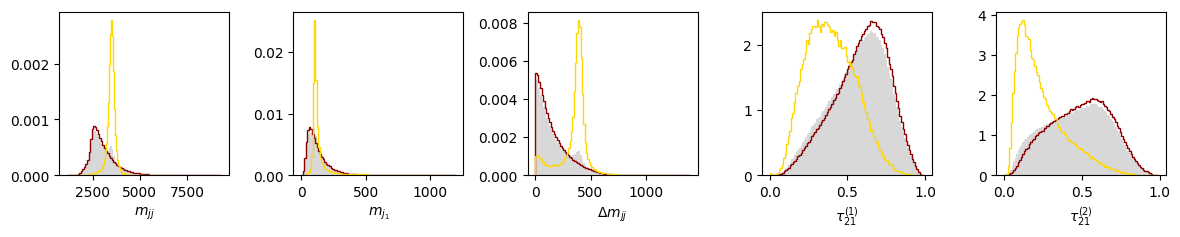

In [86]:
mask = cathode[:, 0] == 0
cathode_background = cathode[mask]
cathode_signal = cathode[~mask]


# plot in un plot 5 features above
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 5, figsize=(12, 2.5))
ax[0].hist(cathode[:,1], bins=100, histtype='stepfilled', color='gray', label='background', density=True, alpha=0.3)
ax[0].hist(cathode_background[:,1], bins=100, histtype='step', color='darkred', label='background', density=True)
ax[0].hist(cathode_signal[:,1], bins=100, histtype='step', color='gold', label='signal', density=True)
ax[0].set_xlabel(r'$m_{jj}$')

ax[1].hist(cathode[:,2], bins=100, histtype='stepfilled', color='gray', label='background', density=True, alpha=0.3)
ax[1].hist(cathode_background[:,2], bins=100, histtype='step', color='darkred', label='background', density=True)
ax[1].hist(cathode_signal[:,2], bins=100, histtype='step', color='gold', label='signal', density=True)
ax[1].set_xlabel(r'$m_{j_1}$')

ax[2].hist(cathode[:,3], bins=100, histtype='stepfilled', color='gray', label='background', density=True, alpha=0.3)
ax[2].hist(cathode_background[:,3], bins=100, histtype='step', color='darkred', label='background', density=True)
ax[2].hist(cathode_signal[:,3], bins=100, histtype='step', color='gold', label='signal', density=True)
ax[2].set_xlabel(r'$\Delta m_{jj}$')

ax[3].hist(cathode[:,4], bins=100, histtype='stepfilled', color='gray', label='background', density=True, alpha=0.3)
ax[3].hist(cathode_background[:,4], bins=100, histtype='step', color='darkred', label='background', density=True)
ax[3].hist(cathode_signal[:,4], bins=100, histtype='step', color='gold', label='signal', density=True)
ax[3].set_xlabel(r'$\tau_{21}^{(1)}$')

ax[4].hist(cathode[:,5], bins=100, histtype='stepfilled', color='gray', label='background', density=True, alpha=0.3)
ax[4].hist(cathode_background[:,5], bins=100, histtype='step', color='darkred', label='background', density=True)
ax[4].hist(cathode_signal[:,5], bins=100, histtype='step', color='gold', label='signal', density=True)
ax[4].set_xlabel(r'$\tau_{21}^{(2)}$')


# ax[5].hist(cathode_background[:,6], bins=100, histtype='step', color='darkred', label='background', density=True)
# ax[5].hist(cathode_signal[:,6], bins=100, histtype='step', color='gold', label='signal', density=True)
# ax[5].set_xlabel(r'$\Delta R_{jj}$')

plt.tight_layout()
plt.show()


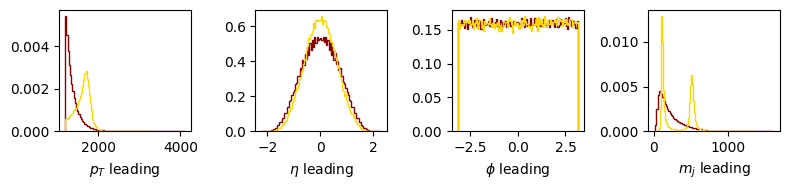

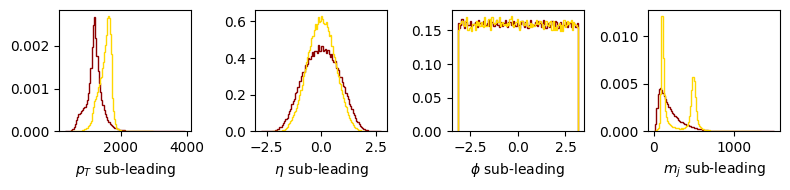

In [72]:
mask = low_level[:, 0] == 0
low_level_background = low_level[mask]
low_level_signal = low_level[~mask]

fig, ax = plt.subplots(1, 4, figsize=(8, 2))
ax[0].hist(low_level_background[:,2], bins=100, histtype='step', color='darkred', label='background', density=True)
ax[0].hist(low_level_signal[:,2], bins=100, histtype='step', color='gold', label='signal', density=True)
ax[0].set_xlabel(r'$p_T$ leading')

ax[1].hist(low_level_background[:,3], bins=100, histtype='step', color='darkred', label='background', density=True)
ax[1].hist(low_level_signal[:,3], bins=100, histtype='step', color='gold', label='signal', density=True)
ax[1].set_xlabel(r'$\eta$ leading')

ax[2].hist(low_level_background[:,4], bins=100, histtype='step', color='darkred', label='background', density=True)
ax[2].hist(low_level_signal[:,4], bins=100, histtype='step', color='gold', label='signal', density=True)
ax[2].set_xlabel(r'$\phi$ leading')

ax[3].hist(low_level_background[:,5], bins=100, histtype='step', color='darkred', label='background', density=True)
ax[3].hist(low_level_signal[:,5], bins=100, histtype='step', color='gold', label='signal', density=True)
ax[3].set_xlabel(r'$m_j$ leading')

plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4, figsize=(8, 2))
ax[0].hist(low_level_background[:,6], bins=100, histtype='step', color='darkred', label='background', density=True)
ax[0].hist(low_level_signal[:,6], bins=100, histtype='step', color='gold', label='signal', density=True)
ax[0].set_xlabel(r'$p_T$ sub-leading')

ax[1].hist(low_level_background[:,7], bins=100, histtype='step', color='darkred', label='background', density=True)
ax[1].hist(low_level_signal[:,7], bins=100, histtype='step', color='gold', label='signal', density=True)
ax[1].set_xlabel(r'$\eta$ sub-leading')

ax[2].hist(low_level_background[:,8], bins=100, histtype='step', color='darkred', label='background', density=True)
ax[2].hist(low_level_signal[:,8], bins=100, histtype='step', color='gold', label='signal', density=True)
ax[2].set_xlabel(r'$\phi$ sub-leading')

ax[3].hist(low_level_background[:,9], bins=100, histtype='step', color='darkred', label='background', density=True)
ax[3].hist(low_level_signal[:,9], bins=100, histtype='step', color='gold', label='signal', density=True)
ax[3].set_xlabel(r'$m_j$ sub-leading')

plt.tight_layout()
plt.show()

In [ ]:
# save low level features to h5 file

with h5py.File('../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5', 'w') as f:
    f.create_dataset('jet features', data=cathode)


with h5py.File('../data/LHCOlympics2020/events_anomalydetection_low_level_ptepm.h5', 'w') as f:
    f.create_dataset('jet features', data=low_level)

In [6]:
import pandas as pd

file = '../data/LHCOlympics2020/events_anomalydetection_v2.features.h5'
df = pd.read_hdf(file, stop=1000000)

px_j1, py_j1 , pz_j1 , m_j1 = df['pxj1'], df['pyj1'], df['pzj1'], df['mj1']
px_j2, py_j2 , pz_j2 , m_j2 = df['pxj2'], df['pyj2'], df['pzj2'], df['mj2']
e_j1 = np.sqrt( px_j1**2 + py_j1**2 + pz_j1**2 + m_j1**2 )
e_j2 = np.sqrt( px_j2**2 + py_j2**2 + pz_j2**2 + m_j2**2 )
pt_j1 = np.sqrt(px_j1**2 + py_j1**2)
pt_j2 = np.sqrt(px_j2**2 + py_j2**2)
eta_j1 = 0.5 * np.log( (e_j1 + pz_j1) / (e_j1 - pz_j1) )
eta_j2 = 0.5 * np.log( (e_j2 + pz_j2) / (e_j2 - pz_j2) )
phi_j1 = np.arctan2(py_j1, px_j1)
phi_j2 = np.arctan2(py_j2, px_j2)

mjj = np.sqrt( (e_j1 + e_j2)**2 - (px_j1 + px_j2)**2 - (py_j1 + py_j2)**2 - (pz_j1 + pz_j2)**2)
delta_mj = df['mj1'] - df['mj2']  
tau21_1 = df['tau2j1'] / (df['tau1j1'] + 1e-6)
tau21_2 = df['tau2j2'] / (df['tau1j2'] + 1e-6)
label = df['label']

low_level_features_4mom = np.concatenate([label[:, None], mjj[:, None], px_j1[:, None], py_j1[:, None], pz_j1[:, None], e_j1[:, None],  px_j2[:, None], py_j2[:, None], pz_j2[:, None], e_j2[:, None]] , axis=-1)
low_level_features_ptepm = np.concatenate([label[:, None], mjj[:, None], pt_j1[:, None], eta_j1[:, None], phi_j1[:, None], m_j1[:, None],  pt_j2[:, None], eta_j2[:, None], phi_j2[:, None], m_j2[:, None]] , axis=-1)


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

In [256]:

# save high_level_features_cathode to h5 file

with h5py.File('../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5', 'w') as f:
    f.create_dataset('jet features', data=high_level_features_cathode)


In [4]:
# save low level features to h5 file

with h5py.File('../data/LHCOlympics2020/events_anomalydetection_low_level_4mom.h5', 'w') as f:
    f.create_dataset('jet features', data=low_level_features_4mom)

with h5py.File('../data/LHCOlympics2020/events_anomalydetection_low_level_ptepm.h5', 'w') as f:
    f.create_dataset('jet features', data=low_level_features_ptepm)